In [2]:
import matplotlib.pyplot as plt; plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import matplotlib as mpl
import pandas as pd
import librosa
import numpy as np
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import tqdm
import itertools
import scipy.io
import glob

import sys; sys.path.insert(0, '..')
from src.features import *

# FRFs

In [2]:
frfs = []
for violin in ['Klimke', 'Levaggi', 'Stoppani']:
    files = glob.glob(f'../data/raw/CNSM/Admittance/*{violin}*.mat')
    ref = None
    for file in files:
        mat     = scipy.io.loadmat(file)

        sr      = mat['freq'][0, 0]
        n_fft   = mat['npts'][0, 0]
        if n_fft != 32768: continue
        f       = np.linspace(0, sr//2, n_fft//2+1)
        X       = mat['yspec'][:, 1]
        Y       = mat['yspec'][:, 0]

        x = np.fft.irfft(X, n_fft)
        y = np.fft.irfft(Y, n_fft)

        x = librosa.resample(x, orig_sr=sr, target_sr=10000)
        y = librosa.resample(y, orig_sr=sr, target_sr=10000)

        X = np.fft.rfft(x, 1024)
        Y = np.fft.rfft(y, 1024)

        sr = 10000
        n_fft = 1024
        f = np.linspace(0, sr//2, n_fft//2+1)
        H       = np.abs(Y / X)
        H       = 20 * np.log10(H)

        if type(ref) != np.ndarray:
            ref = H
        
        a = (H - ref).sum() / len(H)
        H += a

        frf = {
            'file': file,
            'violin': violin,
            'sr': sr,
            'n_fft': n_fft,
            'f': f,
            'X': X,
            'Y': Y,
            'H': H,
        }
        frfs.append(frf)

frfs = pd.DataFrame(frfs)

5000
41


/tmp/ipykernel_90709/2310741097.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(row['f'][0][mask], row['H', 'mean'][mask], c=color[row.name], alpha=.5)
/tmp/ipykernel_90709/2310741097.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row['f'][0][mask],


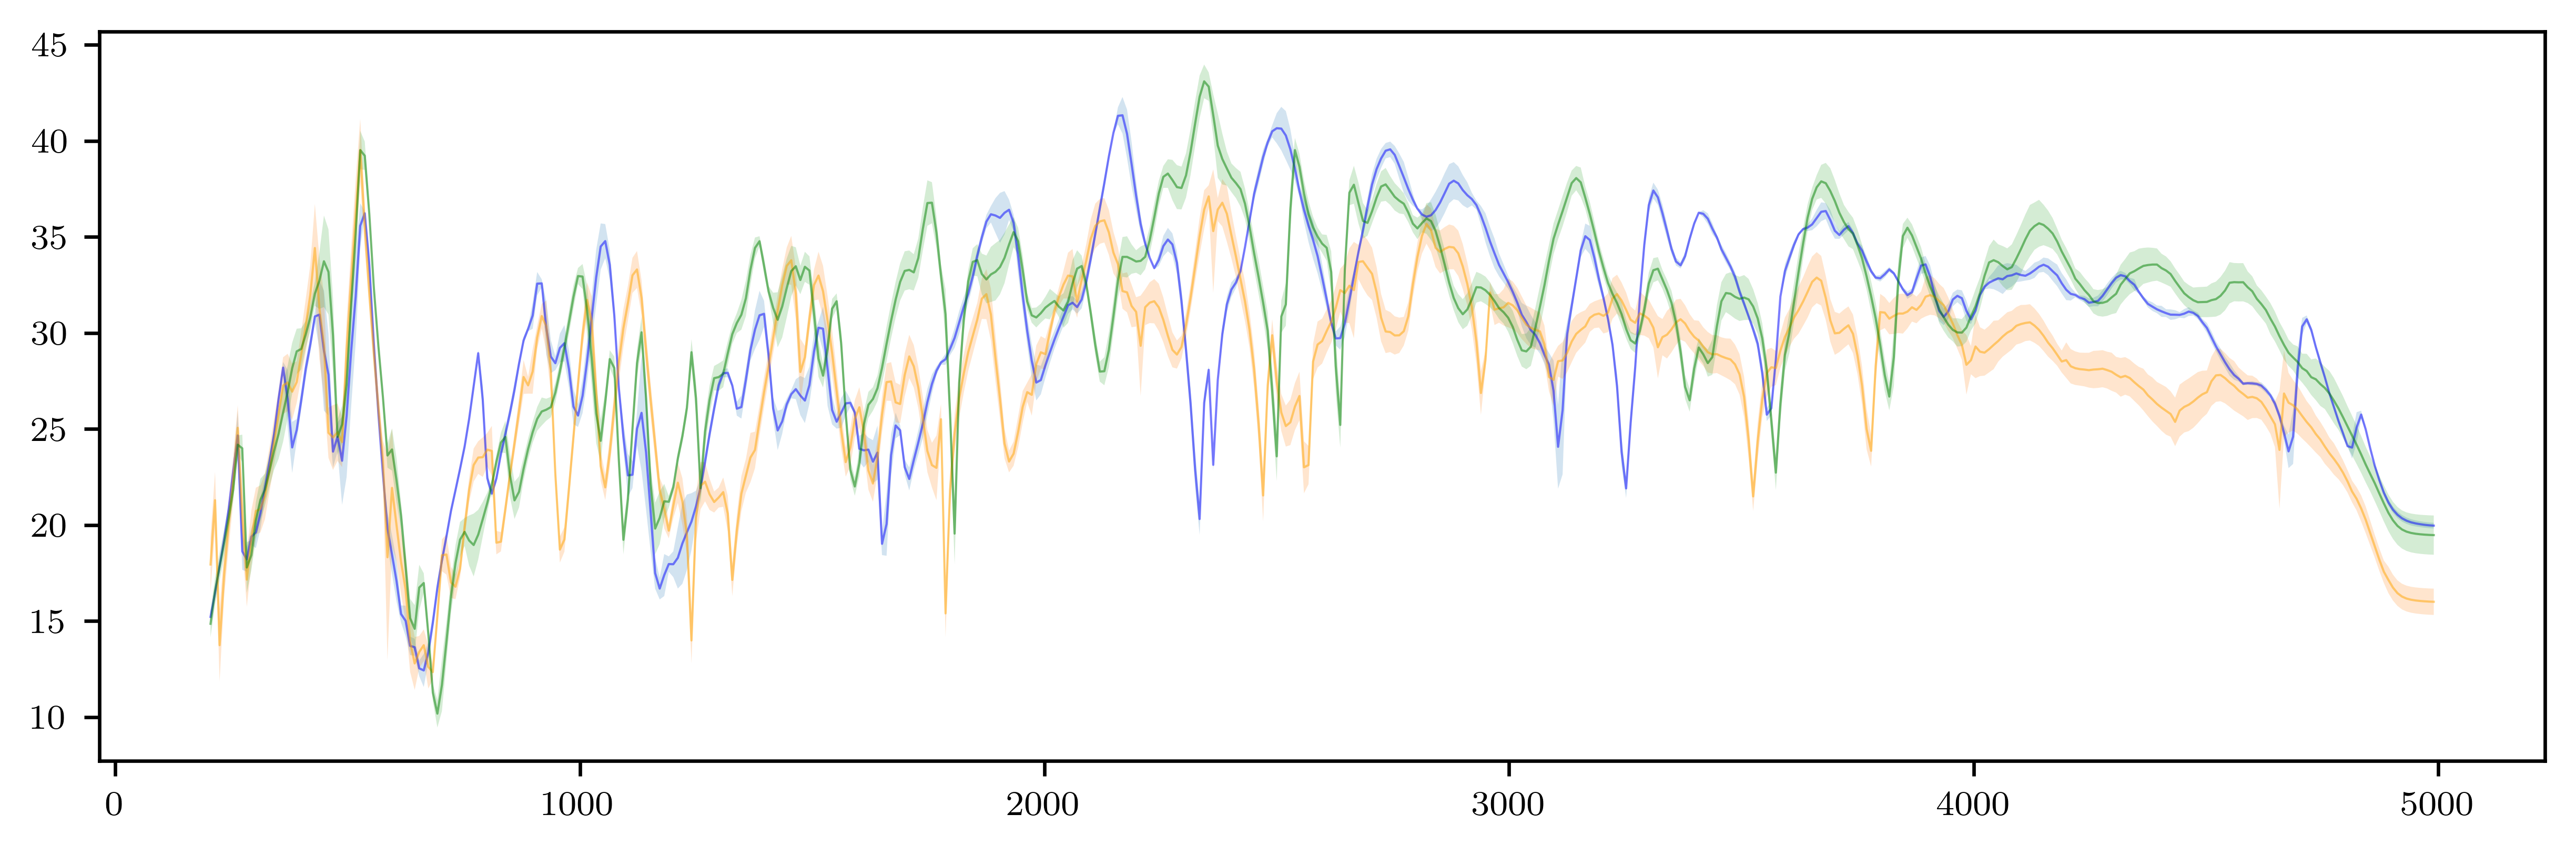

In [5]:
# std fix for numpy arrays dataframes
def std(group):
    group = np.vstack(group)
    std = np.std(group, axis=0)
    return std

def moving_average(a, n=170):
    # ret = np.cumsum(a, dtype=float)
    # ret[n:] = ret[n:] - ret[:-n]
    # return ret[n - 1:] / n
    # return ret / n
    return np.convolve(a, np.ones(n), 'same') / n

# Plot only between f1 and f2
mask = (frfs.f[0] > 200) & (frfs.f[0] < 5000)

color = {
    'Klimke': 'blue',
    'Levaggi': 'orange',
    'Stoppani': 'green'
}

# Sliding window of 250Hz
print((frfs.sr[0]//2 ))
window = int(400 / ((frfs.sr[0]//2) / (frfs.n_fft[0]//2 + 1)))
print(window)

frfs['H_smoothed'] = frfs['H'].apply(moving_average, n=window)
frfs['H_smoothed'] = frfs['H_smoothed'].apply(lambda x : x)

mpl.rcParams['lines.linewidth'] = .5
fig, ax = plt.subplots(figsize=(10, 3))
stats = frfs.groupby('violin')[['H', 'H_smoothed']].agg(['mean', std])

stats['f'] = frfs.groupby('violin')['f'].first()

for i, row in stats.iterrows():
    # ax.plot(row['f'][0][mask], row['H', 'mean'][mask])
    # ax.plot(row['f'][0][mask], row['H', 'mean'][mask])
    ax.plot(row['f'][0][mask], row['H', 'mean'][mask], c=color[row.name], alpha=.5)
    ax.fill_between(
        row['f'][0][mask],
        row['H', 'mean'][mask] + row['H', 'std'][mask],
        row['H', 'mean'][mask] - row['H', 'std'][mask],
        alpha=.2
    )
# ax.set_xscale('log')
# ax.set_xlim([200, 6000])

(200.0, 6000.0)

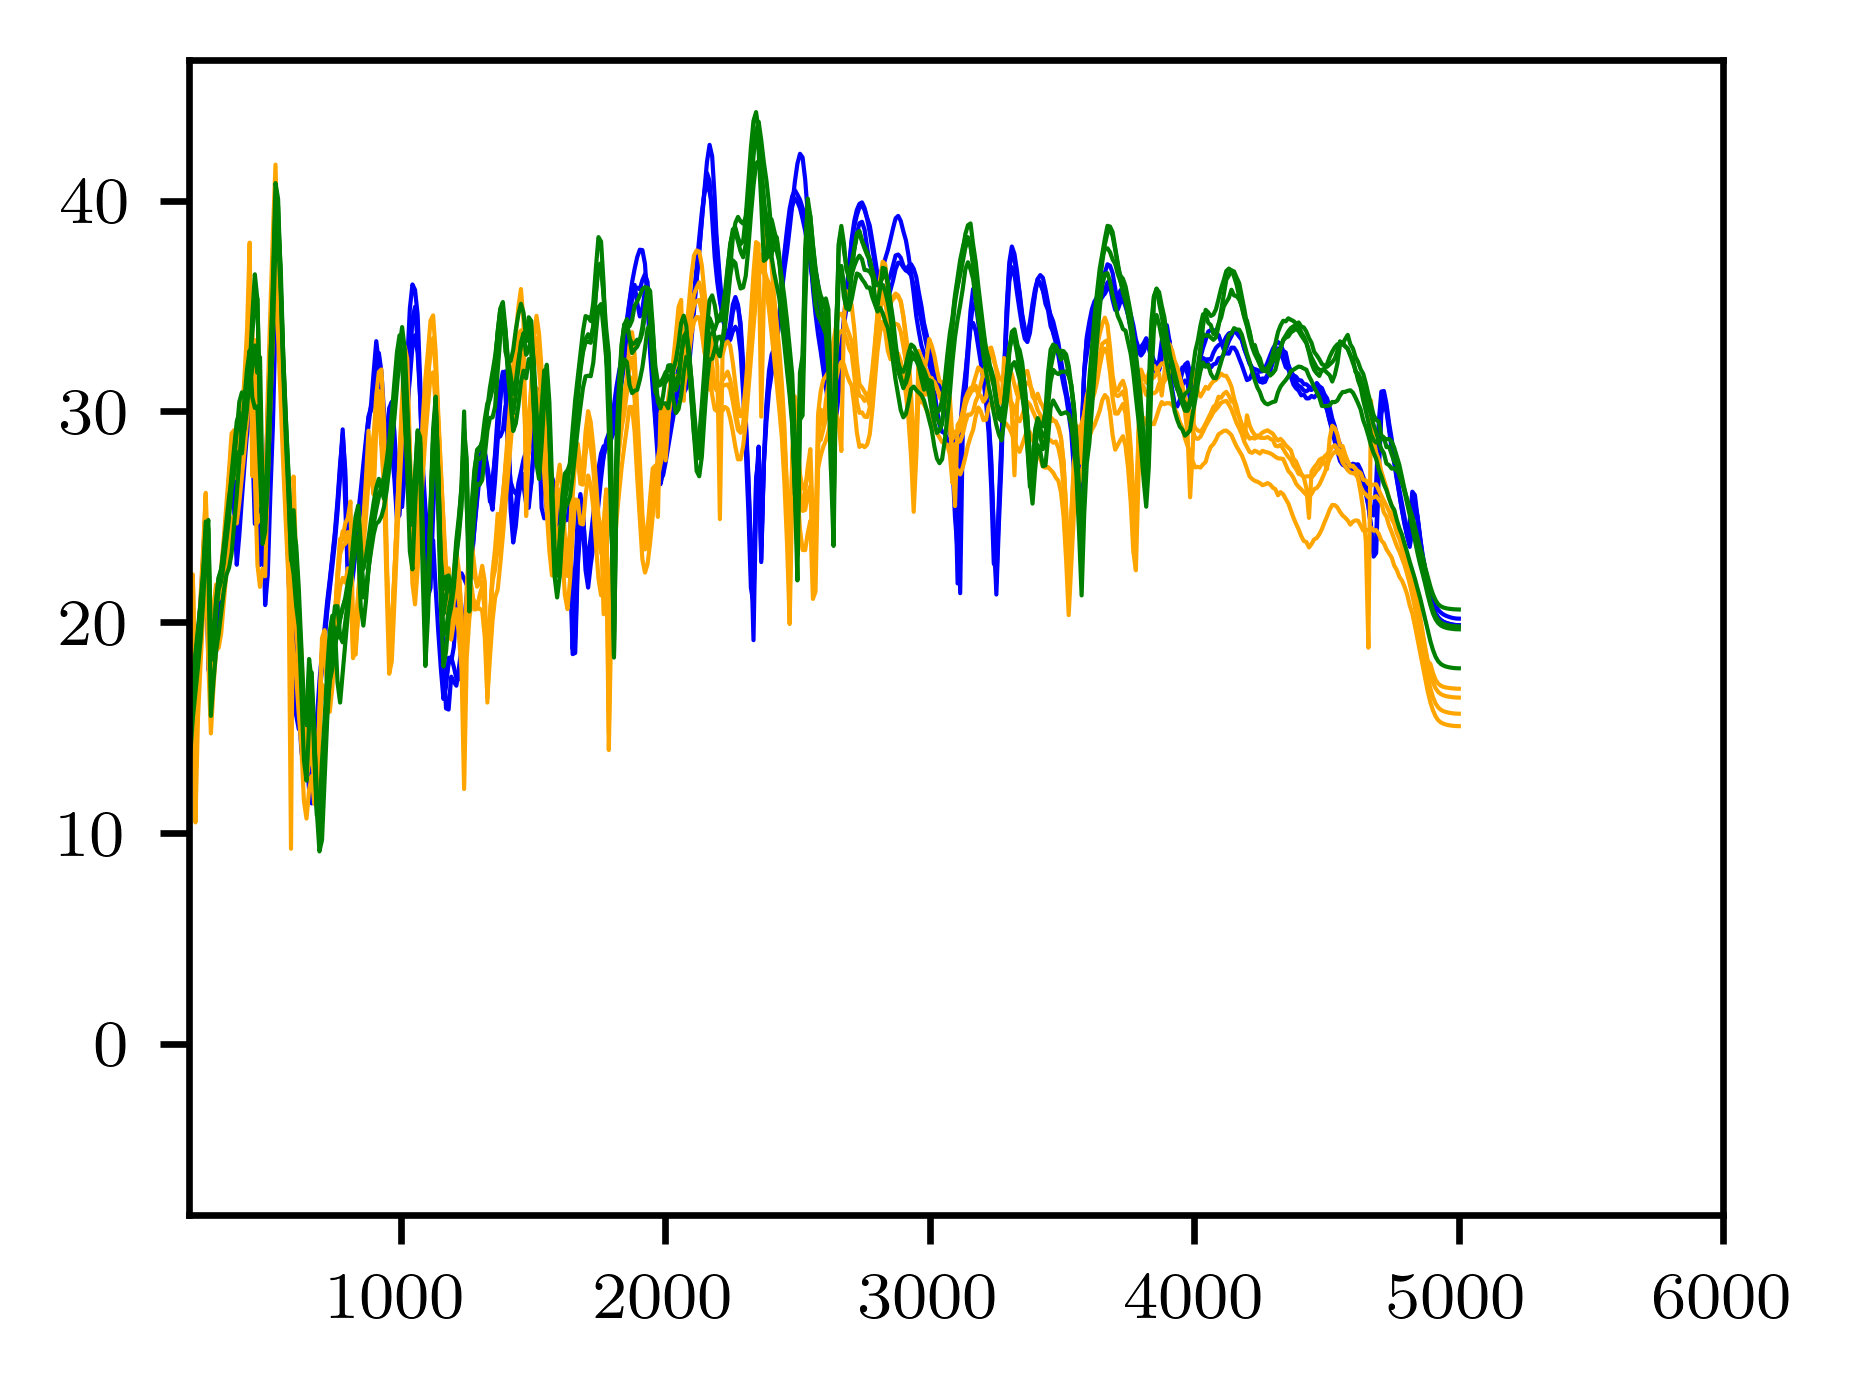

In [529]:
for i, row in frfs.iterrows():
    plt.plot(row['f'], row['H'], c=color[row.violin])

plt.xlim([200, 6000])

# LTAS

In [38]:
sr      = 10000
n_fft   = 1024

df = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
df = df[(df.extract == 'gamme')]

ltass = []
for violin in ['A', 'B', 'C']:
    ref = None
    for i, row in df[(df.violin == violin)].iloc[:].iterrows():
        audio, sr = librosa.load(
            row.file, 
            offset=row.start, 
            duration=row.end - row.start, 
            sr=sr
        )
        audio /= audio.max()
        f       = np.linspace(0, sr//2, n_fft//2+1)
        # ltas    = LTAS(audio, n_fft, n_fft//5)
        ltas = librosa.stft(y=audio, n_fft=n_fft, hop_length=n_fft//2).T
        ltas = np.abs(ltas)**2
        ltas = np.max(ltas, axis=0)
        # ltas    = ltas / ltas[:100].max()

        ltas    = 20 * np.log(ltas)
        
        if type(ref) != np.ndarray:
            ref = ltas
        a = (ltas - ref).sum() / len(ltas)
        ltas += a

        ltas = {
            'file': row.file,
            'violin': violin,
            'sr': sr,
            'n_fft': n_fft,
            'f': f,
            'H': ltas,
        }
        ltass.append(ltas)

ltass = pd.DataFrame(ltass)

(200.0, 4000.0)

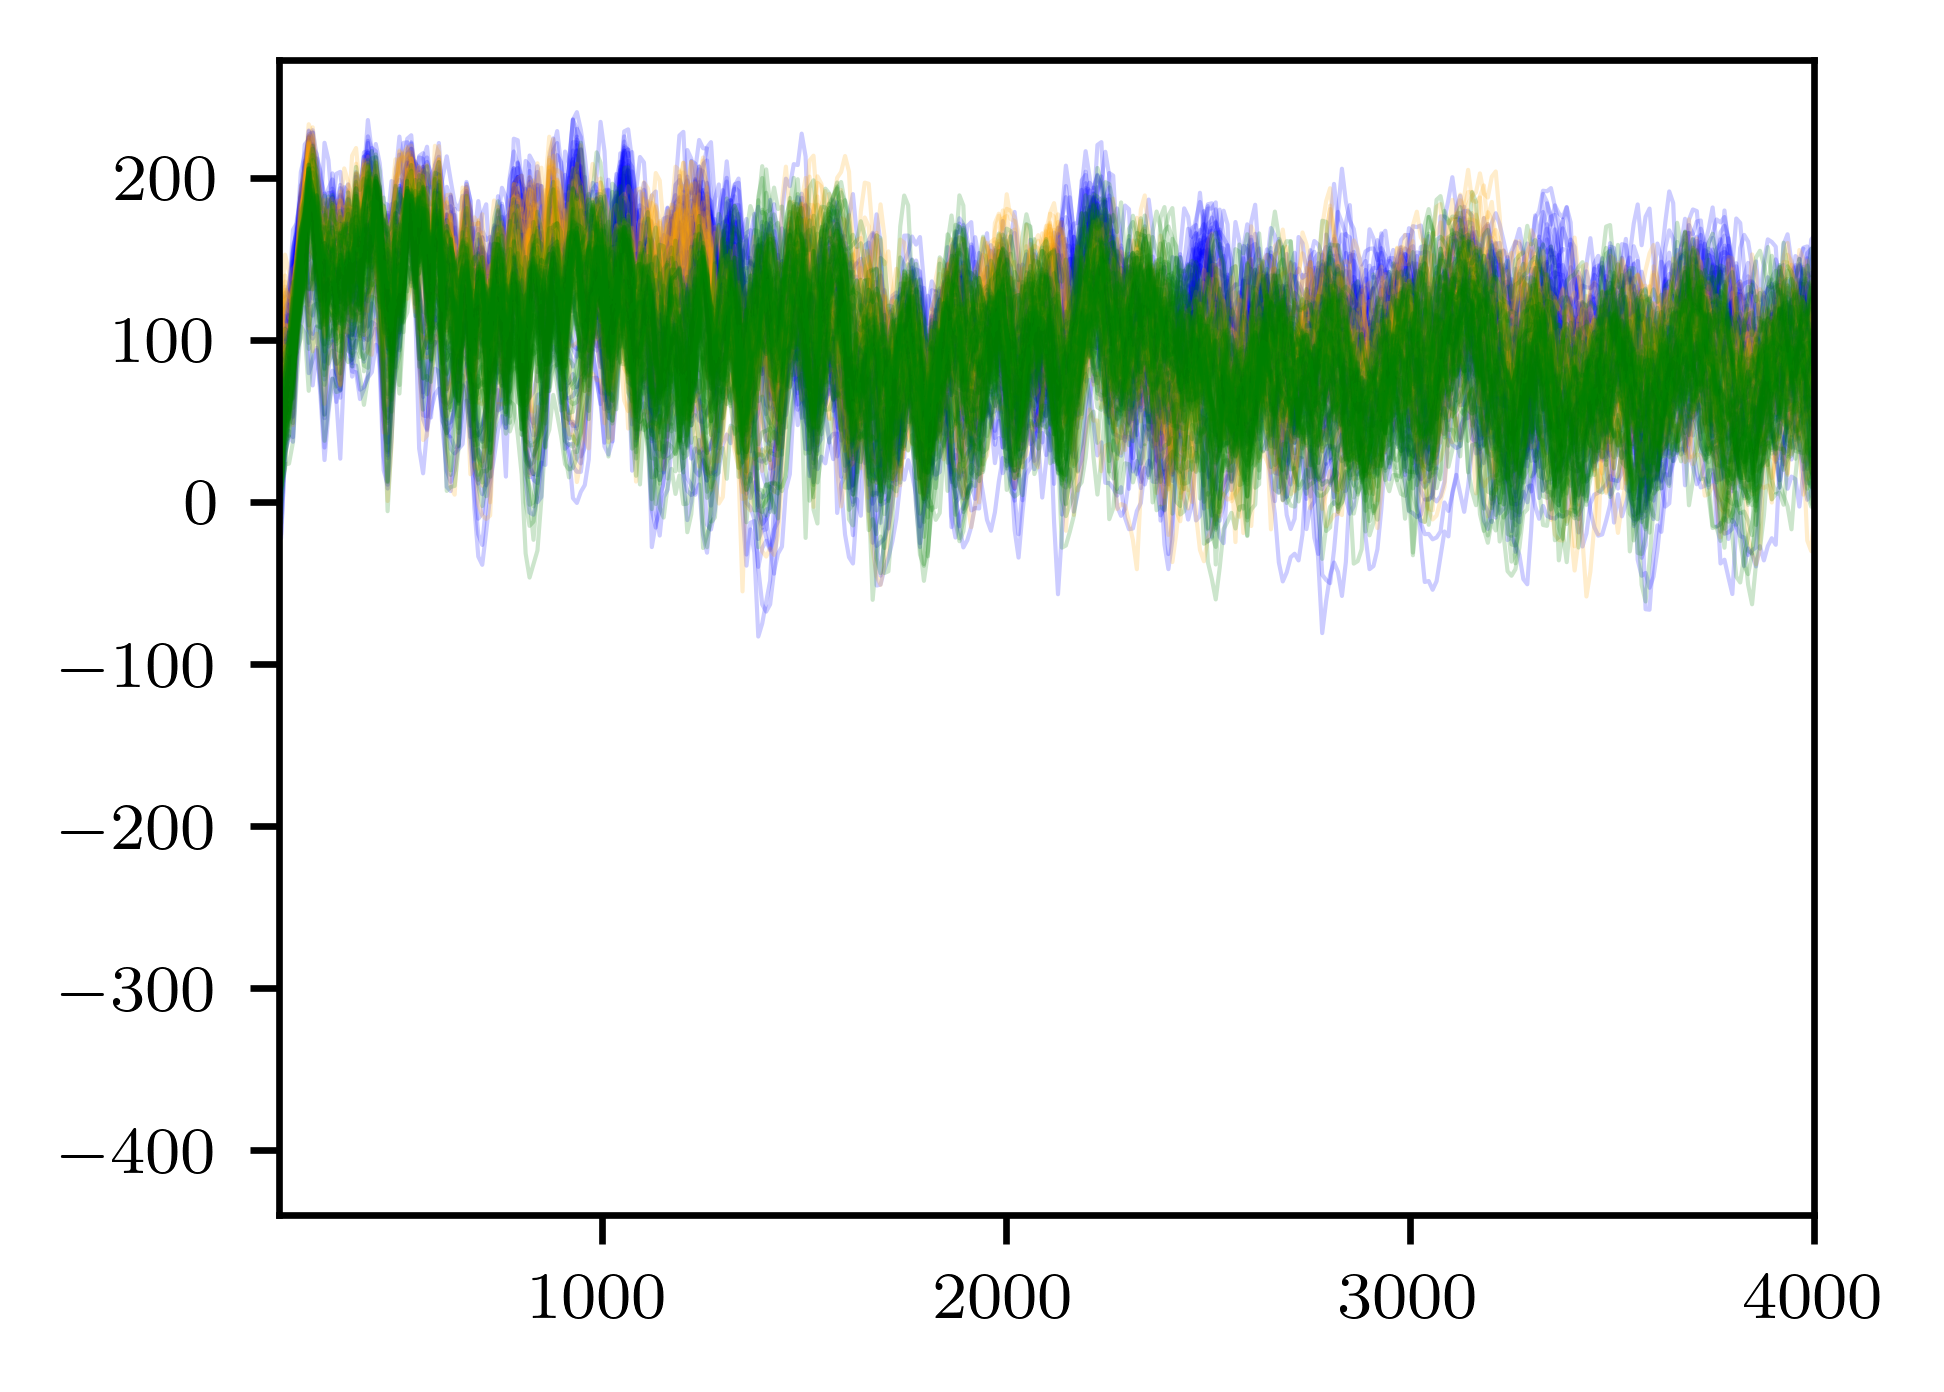

In [40]:
color = {
    'A': 'blue',
    'B': 'orange',
    'C': 'green'
}
for i, row in ltass.iterrows():
    # if row.violin == 'A':
        plt.plot(row['f'], row['H'], c=color[row.violin], alpha=.2)

plt.xlim([200, 4000])
# plt.ylim([-250, 0])

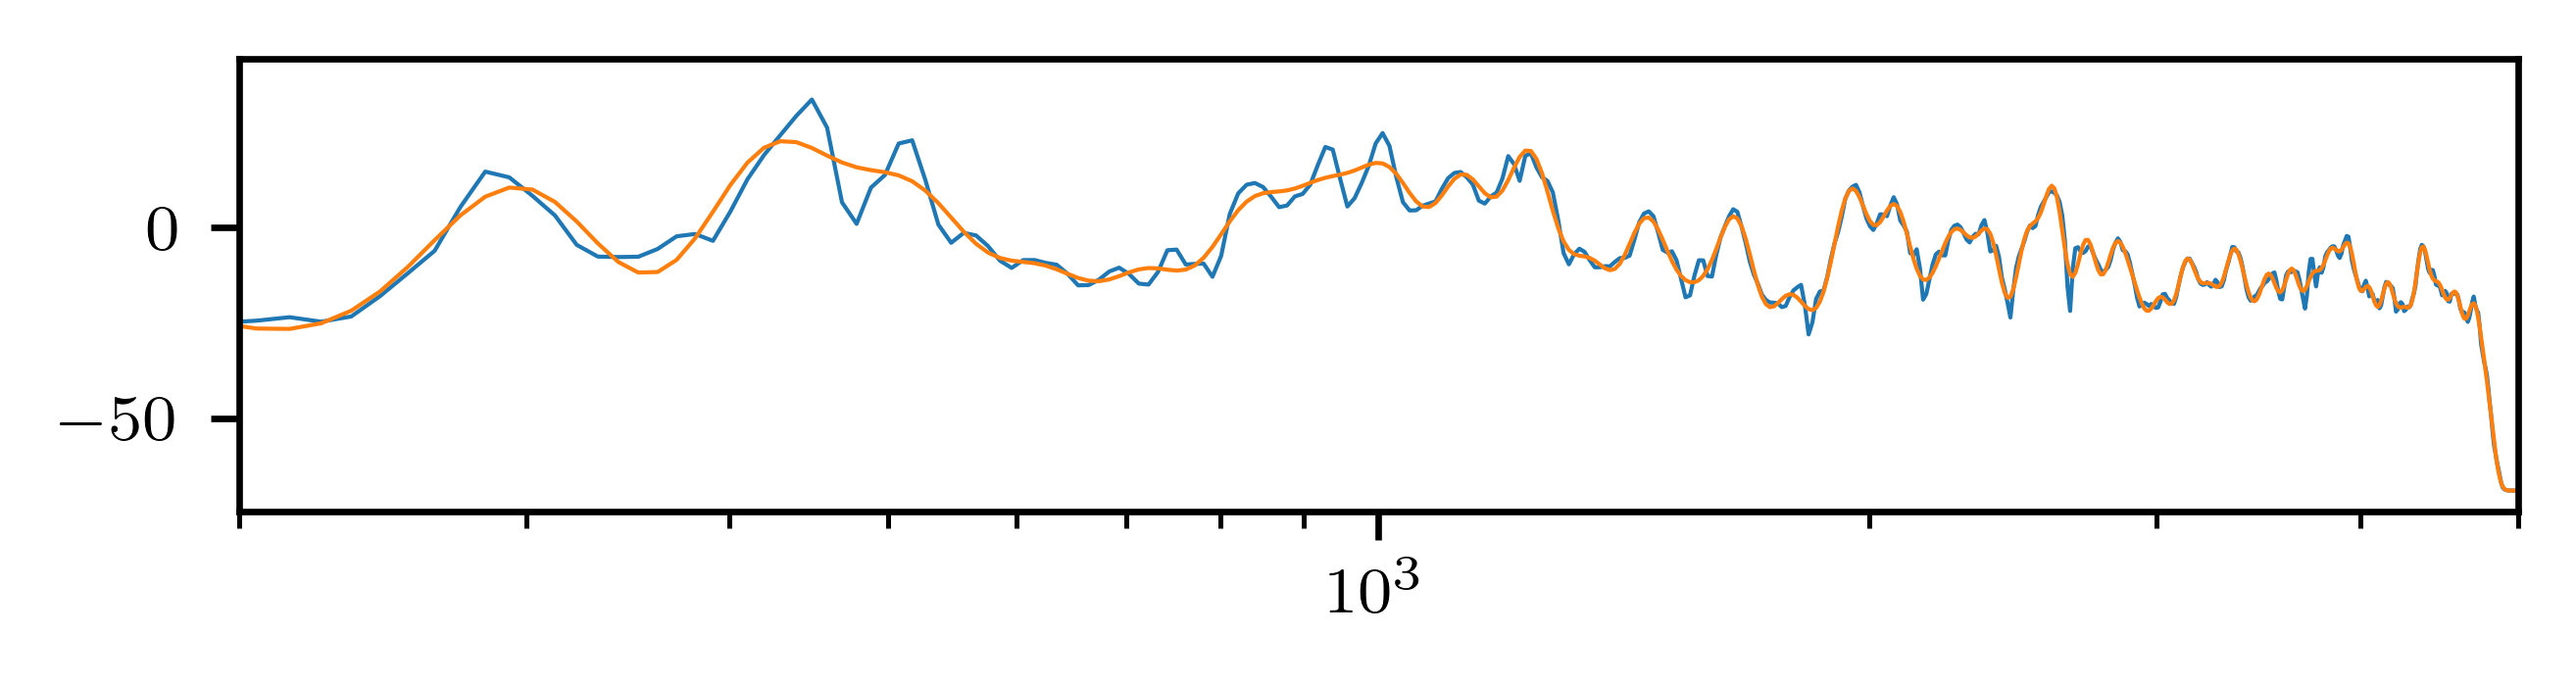

In [125]:
# audio, _ = librosa.load('/run/media/hugo/Hugo/20250123_ATIAM_ALTO_JEU/Audio Files/3-01-Mic.wav', sr=sr, duration=30, offset=10)
sr = 10000
n_fft = 1024
audio, _ = librosa.load('/home/hugo/Downloads/ImpactHammerTests/Impact Hammer WAV files/Plowden each mic collapsed 48k-1.wav', sr=sr)
audio /= audio.max()
f       = np.linspace(0, sr//2, n_fft//2+1)
ltas = librosa.stft(y=audio, n_fft=n_fft, hop_length=n_fft//2).T
ltas = np.abs(ltas)**2
ltas = np.mean(ltas, axis=0)
# ltas = ltas * np.arange(len(ltas))
# ltas = ltas / Ss_mean
ltas    = 10 * np.log(ltas + 0.001)

import scipy.fftpack
envelope = scipy.fftpack.dct(ltas, norm='ortho')
envelope[100:] = 0
envelope = scipy.fftpack.idct(envelope,norm='ortho')

plt.figure(figsize=(5,1))
plt.semilogx(f, ltas)
plt.semilogx(f, envelope)
plt.xlim([200, 5000])
plt.show()

/tmp/ipykernel_93701/2308124860.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].plot(row['f'][0], row['data', 'mean'])
/tmp/ipykernel_93701/2308124860.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row['f'][0],
/tmp/ipykernel_93701/2308124860.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].plot(row['f'][0], row['data', 'mean'])


[[0.89695456 0.88109781 0.86807879]
 [0.89856381 0.88487724 0.87959596]
 [0.88911646 0.86693774 0.87260571]]


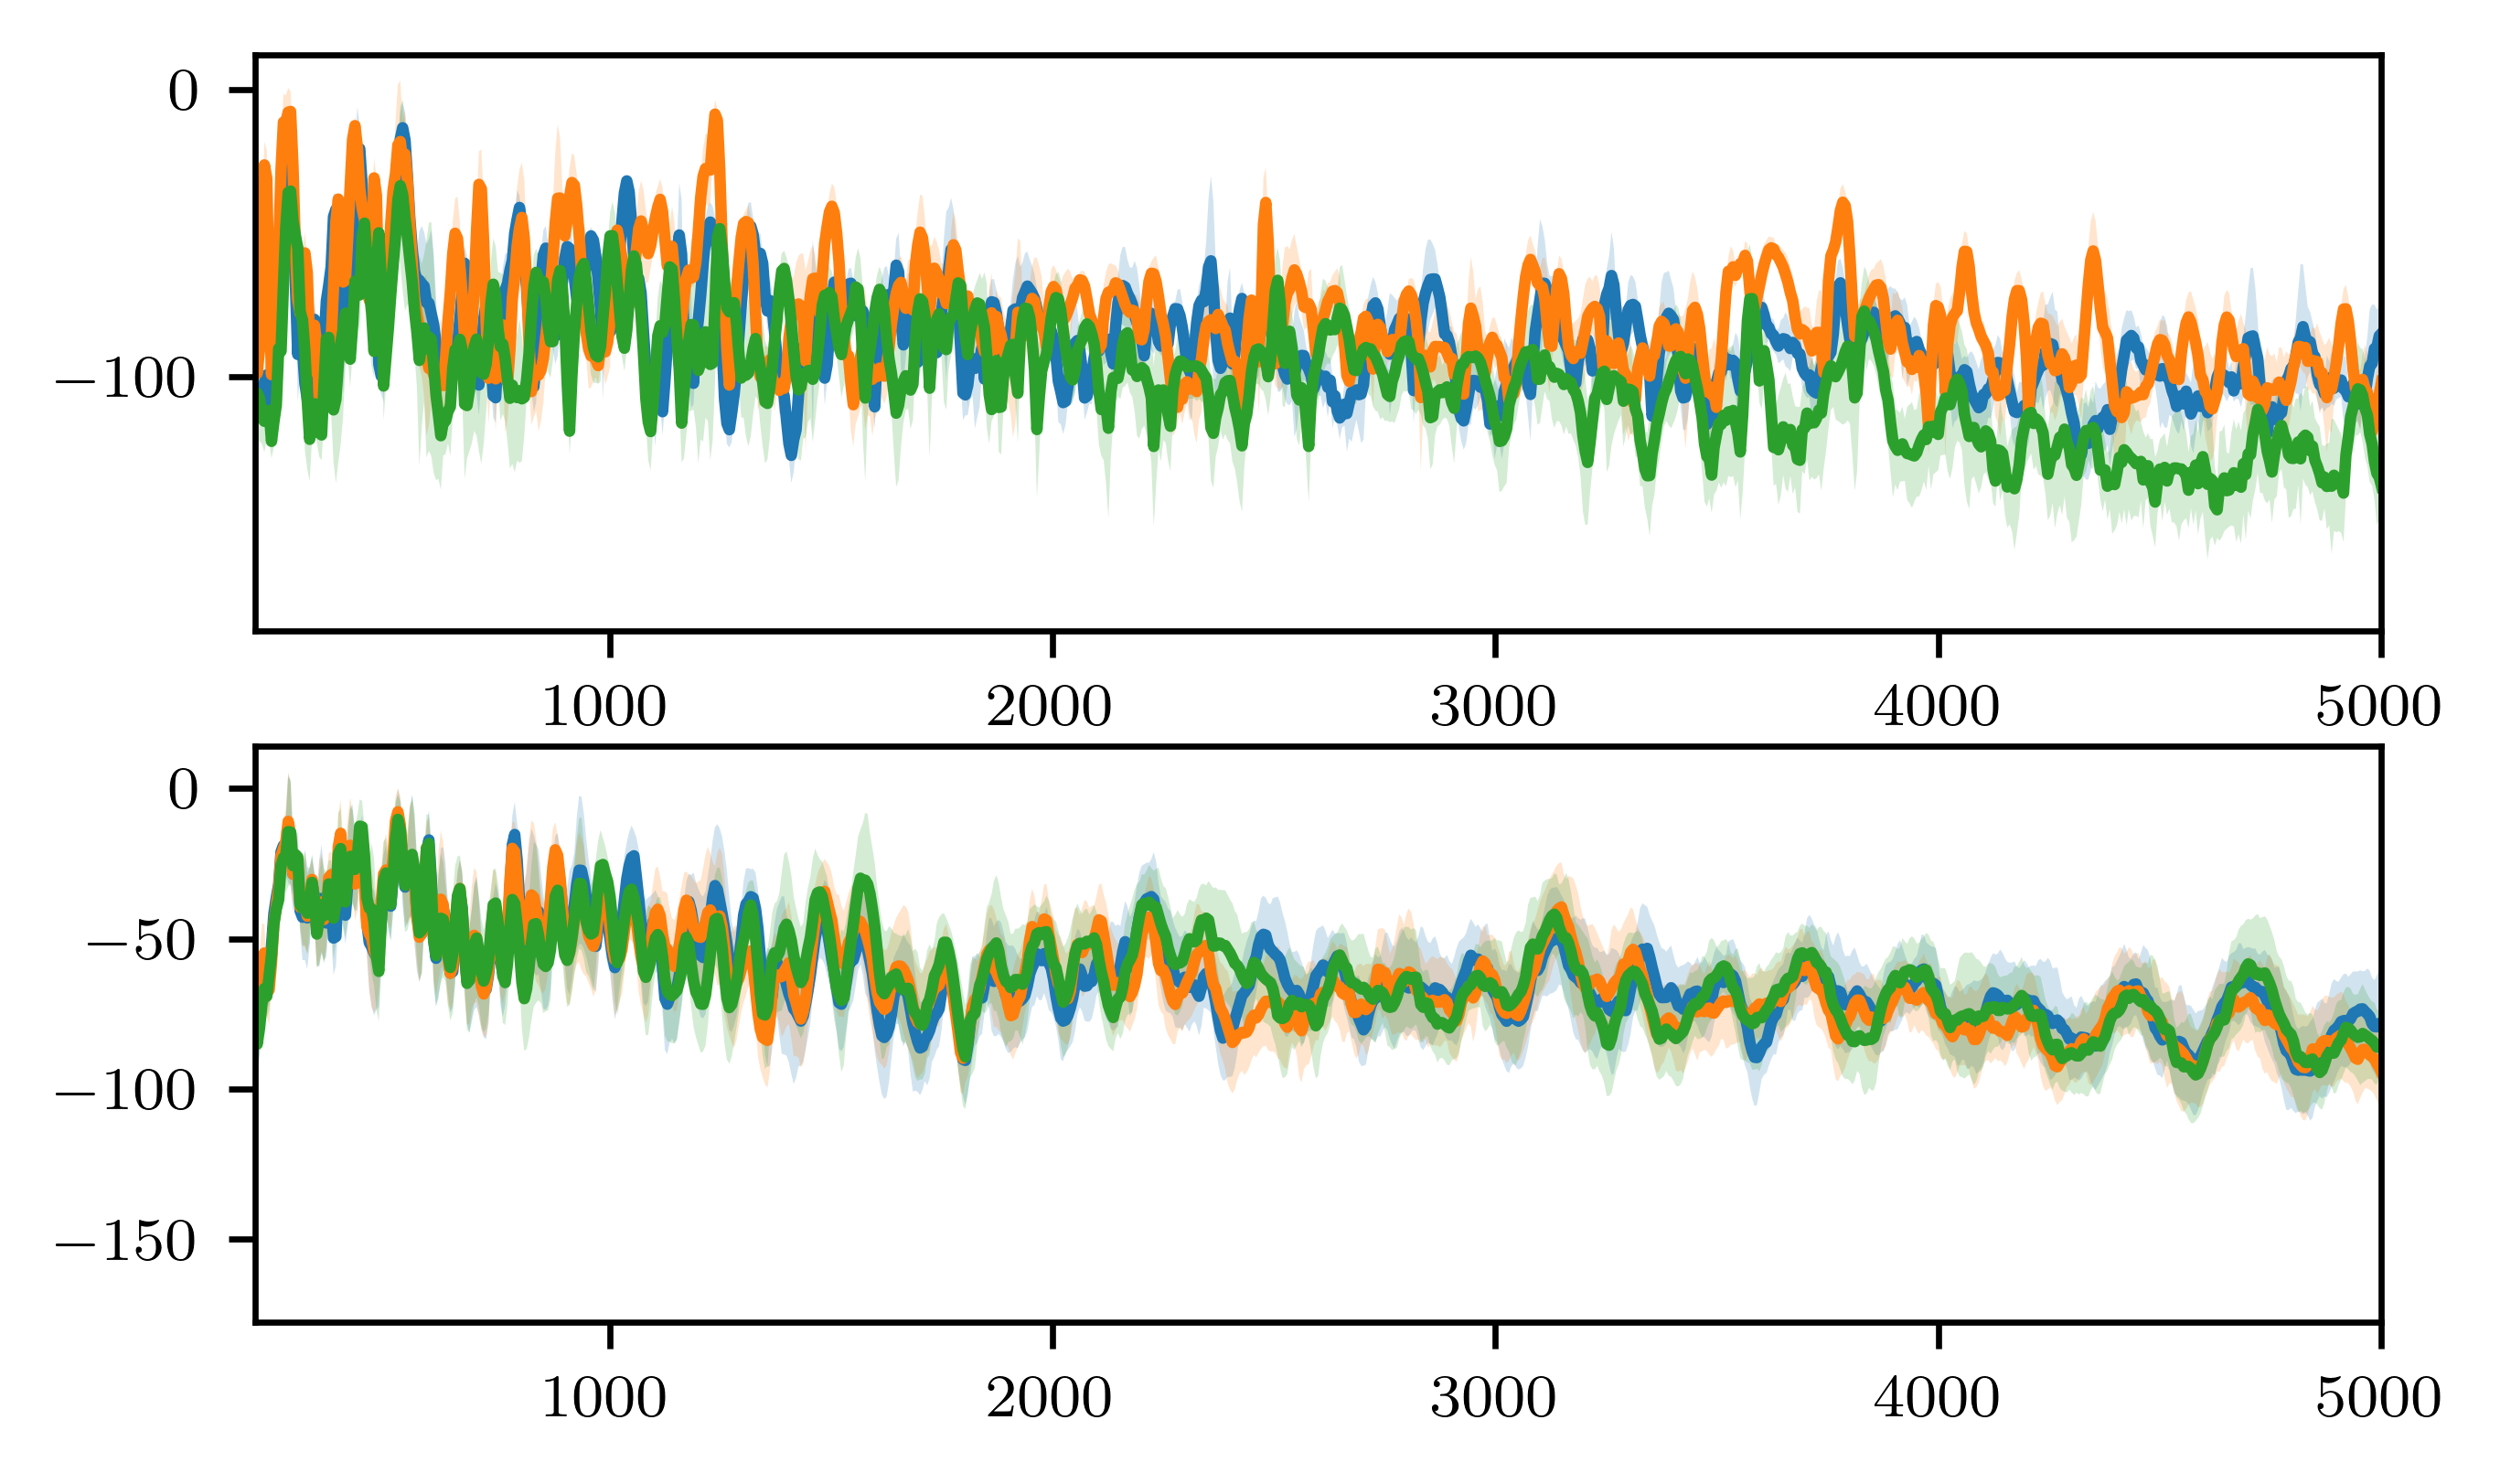

In [175]:
import os, glob

sr = 44100
n_fft = 2048*4
order = 60

def std(group):
    group = np.vstack(group)
    std = np.std(group, axis=0)
    return std

data = []
for i, violin in enumerate(['Klimke', 'Levaggi', 'Stoppani']):
    directory = f"../data/raw/MesuresRayonnement/{violin}_PhDHugo"
    files = glob.glob(f'{directory}/**/*H_001_001.wav', recursive=True)
    for file in files:
        audio, _ = librosa.load(file, sr=sr)
        audio   /= audio.max()
        f       = np.linspace(0, sr//2, n_fft//2+1)
        ltas    = LTAS(audio, n_fft, n_fft//4)
        ltas    = 10 * np.log(ltas + 0.00000001)
        # ltas = scipy.fftpack.dct(ltas, norm='ortho')
        # ltas[order:] = 0
        # ltas = scipy.fftpack.idct(ltas,norm='ortho')
        ltas    -= ltas.max()
        data.append({
            'violin': violin,
            'type': 'admittance',
            'f': f,
            'data': ltas
        })

    letters = ['A', 'B', 'C']
    files = glob.glob(f'../data/processed/{letters[i]}-*-gamme-*.wav', recursive=True)
    for file in files:
        audio, _ = librosa.load(file, sr=sr)
        audio   /= audio.max()
        f       = np.linspace(0, sr//2, n_fft//2+1)
        ltas    = LTAS(audio, n_fft, n_fft//4)
        ltas    = 10 * np.log(ltas + 0.000001)
        # ltas = scipy.fftpack.dct(ltas, norm='ortho')
        # ltas[order:] = 0
        # ltas = scipy.fftpack.idct(ltas,norm='ortho')
        ltas    -= ltas.max()
        data.append({
            'violin': violin,
            'type': 'ltas',
            'f': f,
            'data': ltas
        })

data = pd.DataFrame(data)

stats = data.groupby(['violin', 'type']).agg(['mean', std])


fig, ax = plt.subplots(2, 1, figsize=(5,3))
# ax.set_xlim([200, 5000])
for i, row in stats.iterrows():
    if(row.name[1] == 'admittance'):
        ax[0].plot(row['f'][0], row['data', 'mean'])
        o = 0

    if(row.name[1] == 'ltas'):
        o = 1
        ax[1].plot(row['f'][0], row['data', 'mean'])
    
    ax[o].fill_between(
        row['f'][0],
        row['data', 'mean'] + row['data', 'std'],
        row['data', 'mean'] - row['data', 'std'],
        alpha=.2
    )

# ax.set_xscale('log')

ax[0].set_xlim([200, 5000])
ax[1].set_xlim([200, 5000])
admittances = stats.query('type == "admittance"')['data', 'mean'].to_numpy()
sounds = stats.query('type == "ltas"')['data', 'mean'].to_numpy()
# sounds = np.array([violin['sound_res'] for violin in violins])

distances = np.array([[np.corrcoef(admittance, sound)[0,1] for admittance in admittances] for sound in sounds])

print(distances)

In [73]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# violins = [
#     {
#         "admittance": "/home/hugo/Downloads/ImpactHammerTests/Impact Hammer WAV files/Plowden each mic collapsed 48k-1.wav",
#         "sound": "/home/hugo/Downloads/PlowdenScale.mp3",
#         'color': "red"
#     },
#     {
#         "admittance": "/home/hugo/Downloads/ImpactHammerTests/Impact Hammer WAV files/Willmotte each mic collapsed 48k.wav",
#         "sound": "/home/hugo/Downloads/WilmotteScale.mp3",
#         'color': "green"
#     },
#     {
#         "admittance": "/home/hugo/Downloads/ImpactHammerTests/Impact Hammer WAV files/Titian each mic collapsed 48k-1.wav",
#         "sound": "/home/hugo/Downloads/TitianScale.mp3",
#         'color': "blue"
#     }
# ]

violins = [
    {
        "admittance": "../data/raw/MesuresRayonnement/Klimke_PhDHugo/Klimke 06/Raw/Klimke 06 H_001_001.wav",
        "sound": "../data/processed/A-Clara-gamme-1.wav",
        'color': "red"
    },
    {
        "admittance": "../data/raw/MesuresRayonnement/Levaggi_PhDHugo/Levaggi 01/Raw/Levaggi 01 H_001_001.wav",
        "sound": "../data/processed/B-Clara-gamme-1.wav",
        'color': "green"
    },
    {
        "admittance": "../data/raw/MesuresRayonnement/Stoppani_PhDHugo/Stoppani 02/Raw/Stoppani 02 H_001_001.wav",
        "sound": "../data/processed/C-Clara-gamme-1.wav",
        'color': "blue"
    }
]

sr = 10000
n_fft = 2048

@interact(
    order=widgets.IntSlider(min=10, max=200, step=10, value=90),
    sr=widgets.IntSlider(min=5000, max=44000, step=1000, value=10000),
    power=widgets.IntSlider(min=1, max=8, step=1, value=1),
)
def plot(order=100, sr=10000, power=1):
    n_fft = 256*2**power
    def envelope_db(y, ltas):
        # lpc_coeffs = librosa.lpc(y, order=order)
        # freqs, h = scipy.signal.freqz(1.0, lpc_coeffs, worN=n_fft//2 + 1)
        # envelope = np.abs(h)
        # envelope = 20 * np.log10(envelope + 0.0001)
        # envelope -= envelope.max()

        envelope = scipy.fftpack.dct(ltas, norm='ortho')
        envelope[order:] = 0
        envelope = scipy.fftpack.idct(envelope,norm='ortho')

        return envelope


    fig, ax = plt.subplots(2, 1, figsize=(5,3))

    for violin in violins:
        for i, y in enumerate([violin['admittance'], violin['sound']]):
            audio, _ = librosa.load(y, sr=sr)
            audio   /= audio.max()
            f       = np.linspace(0, sr//2, n_fft//2+1)
            ltas    = LTAS(audio, n_fft, n_fft//4)
            ltas    = 10 * np.log(ltas + 0.0001)
            ltas    -= ltas.max()
            ax[i].plot(f, ltas, c=violin['color'])

            if i == 0:
                envelope = envelope_db(audio, ltas)
                violin['admittance_res'] = envelope
                # ax[0].plot(f, envelope, c=violin['color'], alpha=.5)

            if i == 1:
                envelope = envelope_db(audio, ltas)
                violin['sound_res'] = envelope
                # ax[1].plot(f, envelope, c=violin['color'], alpha=.5)

    admittances = np.array([violin['admittance_res'] for violin in violins])
    sounds = np.array([violin['sound_res'] for violin in violins])

    distances = np.array([[np.corrcoef(admittance, sound)[0,1] for admittance in admittances] for sound in sounds])

    print(distances)

    print(np.diag(distances) - np.max(distances, axis=1))
    notdiag = distances.copy()
    notdiag[np.eye(3, dtype=bool)] = 0
    # print(notdiag)
    print(np.diag(distances) - np.max(notdiag, axis=1))

    # ax[0].set_xscale('log')
    # ax[1].set_xscale('log')
    ax[0].set_xlim([200, 5000])
    ax[1].set_xlim([200, 5000])
    plt.show()



interactive(children=(IntSlider(value=90, description='order', max=200, min=10, step=10), IntSlider(value=1000…

[[0.82927705 0.76404187 0.80296579]
 [0.82811946 0.83418651 0.83263082]
 [0.81696124 0.77312812 0.81449102]]


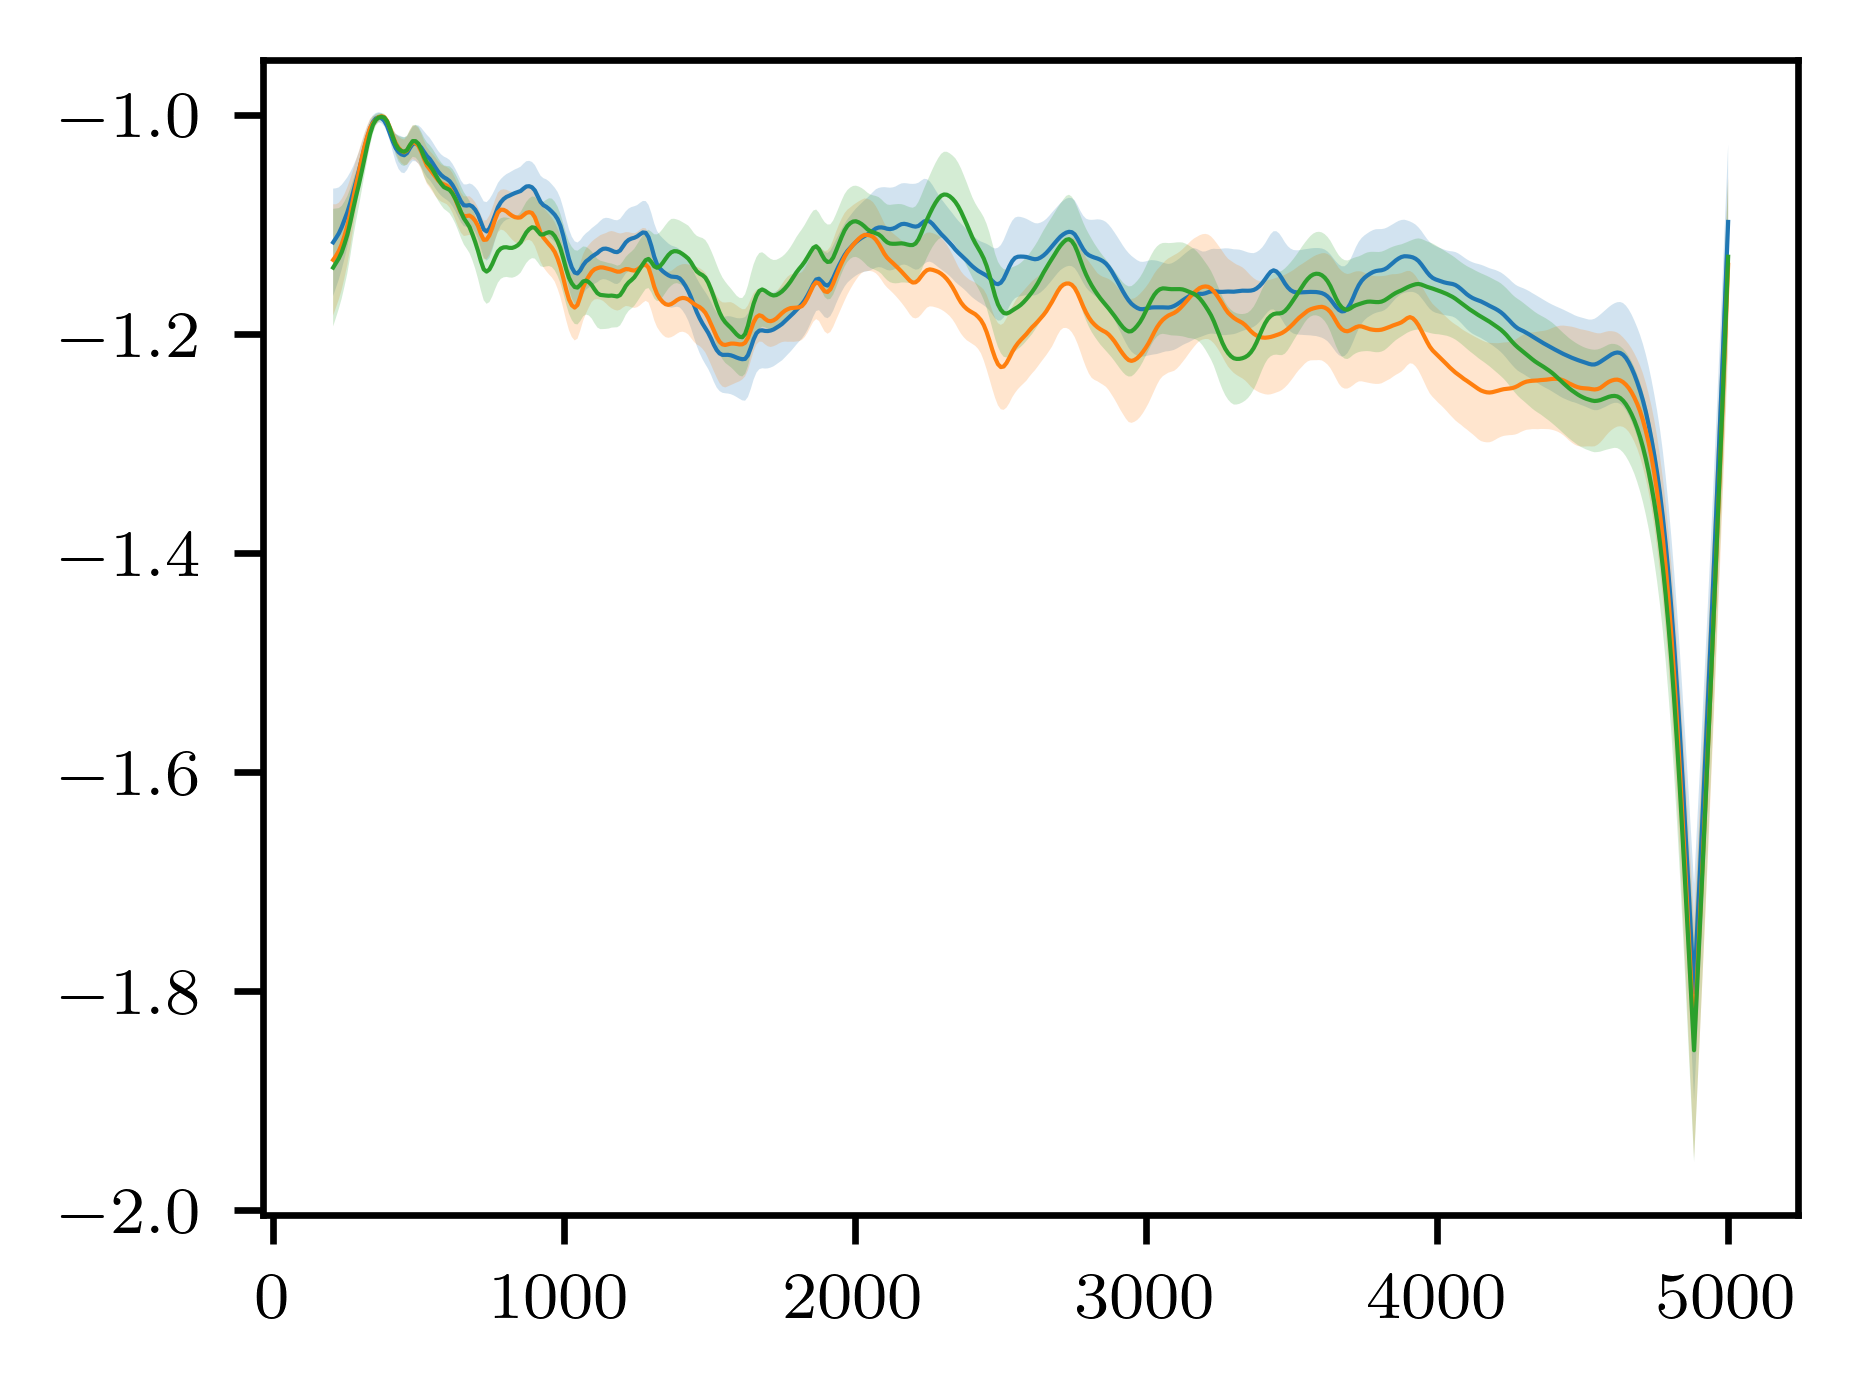

In [525]:
# Plot only between f1 and f2
mask = (ltass.f[0] > 200) & (ltass.f[0] < 50000)

# Sliding window of 250Hz
window = int(250 / ((ltass.sr[0]//2) / (ltass.n_fft[0]//2 + 1)))

ltass['H_smoothed'] = ltass['H'].apply(moving_average, n=window)
ltass['H_smoothed'] = ltass['H_smoothed'].apply(lambda x : -x / x[mask].max())

fig, ax = plt.subplots()
stats = ltass.groupby('violin')[['H', 'H_smoothed']].agg(['mean', std])
stats['f'] = ltass.groupby('violin')['f'].first()

for i, row in stats.iterrows():
    ax.plot(ltass.f[0][mask], row['H_smoothed', 'mean'][mask])
    ax.fill_between(
        ltass.f[0][mask],
        row['H_smoothed', 'mean'][mask] + row['H_smoothed', 'std'][mask],
        row['H_smoothed', 'mean'][mask] - row['H_smoothed', 'std'][mask],
        alpha=.2
    )
# ax.set_xscale('log')
# ax.set_xlim([200, 5000])

/tmp/ipykernel_440092/2149166826.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.plot(row['f'][0][mask], row['H_smoothed', 'mean'][mask])
/tmp/ipykernel_440092/2149166826.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row['f'][0][mask],


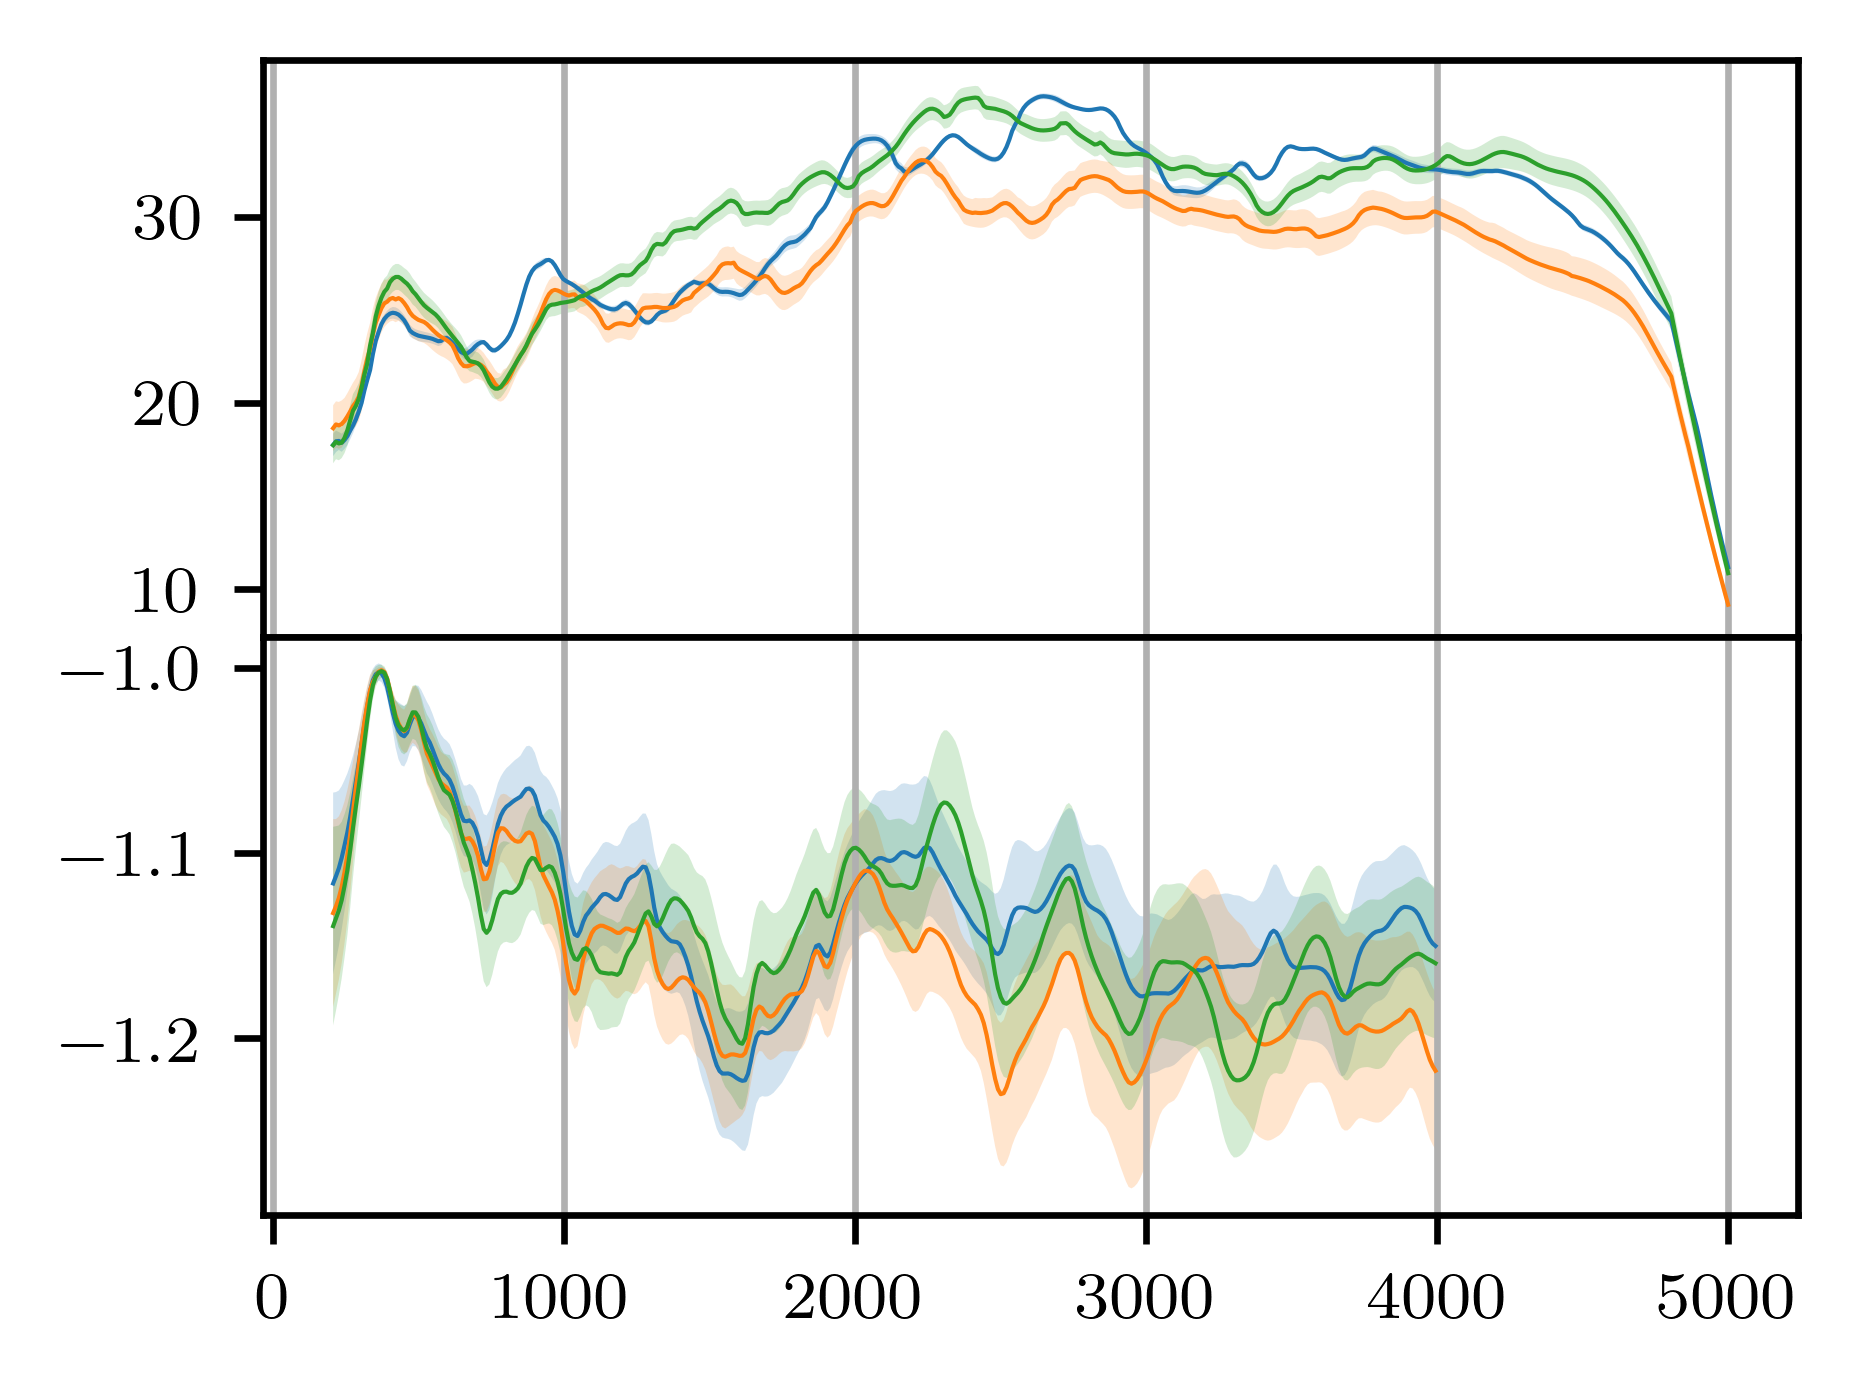

In [530]:
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=.0)

mask = (frfs.f[0] > 200) & (frfs.f[0] < 6000)
stats_frfs = frfs.groupby('violin')[['H', 'H_smoothed']].agg(['mean', std])
stats_frfs['f'] = frfs.groupby('violin')['f'].first()
for i, row in stats_frfs.iterrows():
    # ax.plot(row['f'][0][mask], row['H', 'mean'][mask])
    ax1.plot(row['f'][0][mask], row['H_smoothed', 'mean'][mask])
    ax1.fill_between(
        row['f'][0][mask],
        row['H_smoothed', 'mean'][mask] + row['H_smoothed', 'std'][mask],
        row['H_smoothed', 'mean'][mask] - row['H_smoothed', 'std'][mask],
        alpha=.2
    )


mask = (ltass.f[0] > 200) & (ltass.f[0] < 4000)
stats_ltass = ltass.groupby('violin')[['H', 'H_smoothed']].agg(['mean', std])
stats_ltass['f'] = ltass.groupby('violin')['f'].first()
for i, row in stats_ltass.iterrows():
    ax3.plot(ltass.f[0][mask], row['H_smoothed', 'mean'][mask])
    ax3.fill_between(
        ltass.f[0][mask],
        row['H_smoothed', 'mean'][mask] + row['H_smoothed', 'std'][mask],
        row['H_smoothed', 'mean'][mask] - row['H_smoothed', 'std'][mask],
        alpha=.2
    )

ax.set_xticks(np.arange(3, 4, step=0.1))
ax1.grid(axis='x', which='both')
ax3.grid(axis='x', which='both')
plt.savefig('../reports/figures/admittance-vs-ltas.png', dpi=600, bbox_inches='tight')

In [541]:
s1 = stats_frfs.loc['Stoppani'].H_smoothed['mean'][mask]
s2 = stats_ltass.loc['B'].H_smoothed['mean'][mask]
np.corrcoef(s1, s2)

array([[ 1.        , -0.67403655],
       [-0.67403655,  1.        ]])

In [50]:
# admittance_S /= np.mean(admittance_S[:, admittance_f < 4000])
# recording_S /= np.mean(np.abs(recording_S[:, recording_f < 4000]))

admittance_S_db = 20 * np.log(np.abs(admittance_S) * Ss.mean(axis=0))
# admittance_S_db /= np.mean(admittance_S_db[:, admittance_f < 4000])
admittance_S_mean = np.mean(admittance_S_db, axis=0)
admittance_S_std = np.std(admittance_S_db, axis=0)

recording_S_db = 20 * np.log(np.abs(recording_S))
# recording_S_db /= np.mean(np.abs(recording_S_db)[:, recording_f < 4000])
recordings_S_mean = np.mean(recording_S_db, axis=0)+2
recordings_S_std = np.std(recording_S_db, axis=0)

fig, ax1 = plt.subplots()

ax1.plot(admittance_f, admittance_S_mean)
ax1.fill_between(
    admittance_f, 
    admittance_S_mean + admittance_S_std,
    admittance_S_mean - admittance_S_std,
    alpha=.2
)

ax2 = ax1.twinx()
ax2.plot(recording_f, recordings_S_mean, color='orange')
ax2.fill_between(
    recording_f, 
    recordings_S_mean + recordings_S_std,
    recordings_S_mean - recordings_S_std,
    color='orange',
    alpha=.2
)
ax1.set_xscale('log')
ax1.set_xlim([200, 5000])
# ax1.set_ylim([-100, 100])

NameError: name 'admittance_S' is not defined

In [191]:
correlation = np.corrcoef(admittance_S_mean[admittance_f < 5000], recordings_S_mean[ admittance_f < 5000])
print(correlation)

[[1.         0.18066414]
 [0.18066414 1.        ]]


In [62]:
def sawtooth(f0, n_fft, sr):
    S = np.zeros(n_fft // 2 + 1, dtype=complex)
    df = sr / n_fft

    max_harmonic = (sr/2) // f0
    harmonics = np.arange(1, max_harmonic + 1)
    amplitudes = -1j * (1 / harmonics)

    S[(harmonics * f0 / df).astype(int)] = amplitudes
    return np.abs(S)

/tmp/ipykernel_90709/4012643660.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0, sr//2, n_fft//2+1), np.log10(Ss_mean))


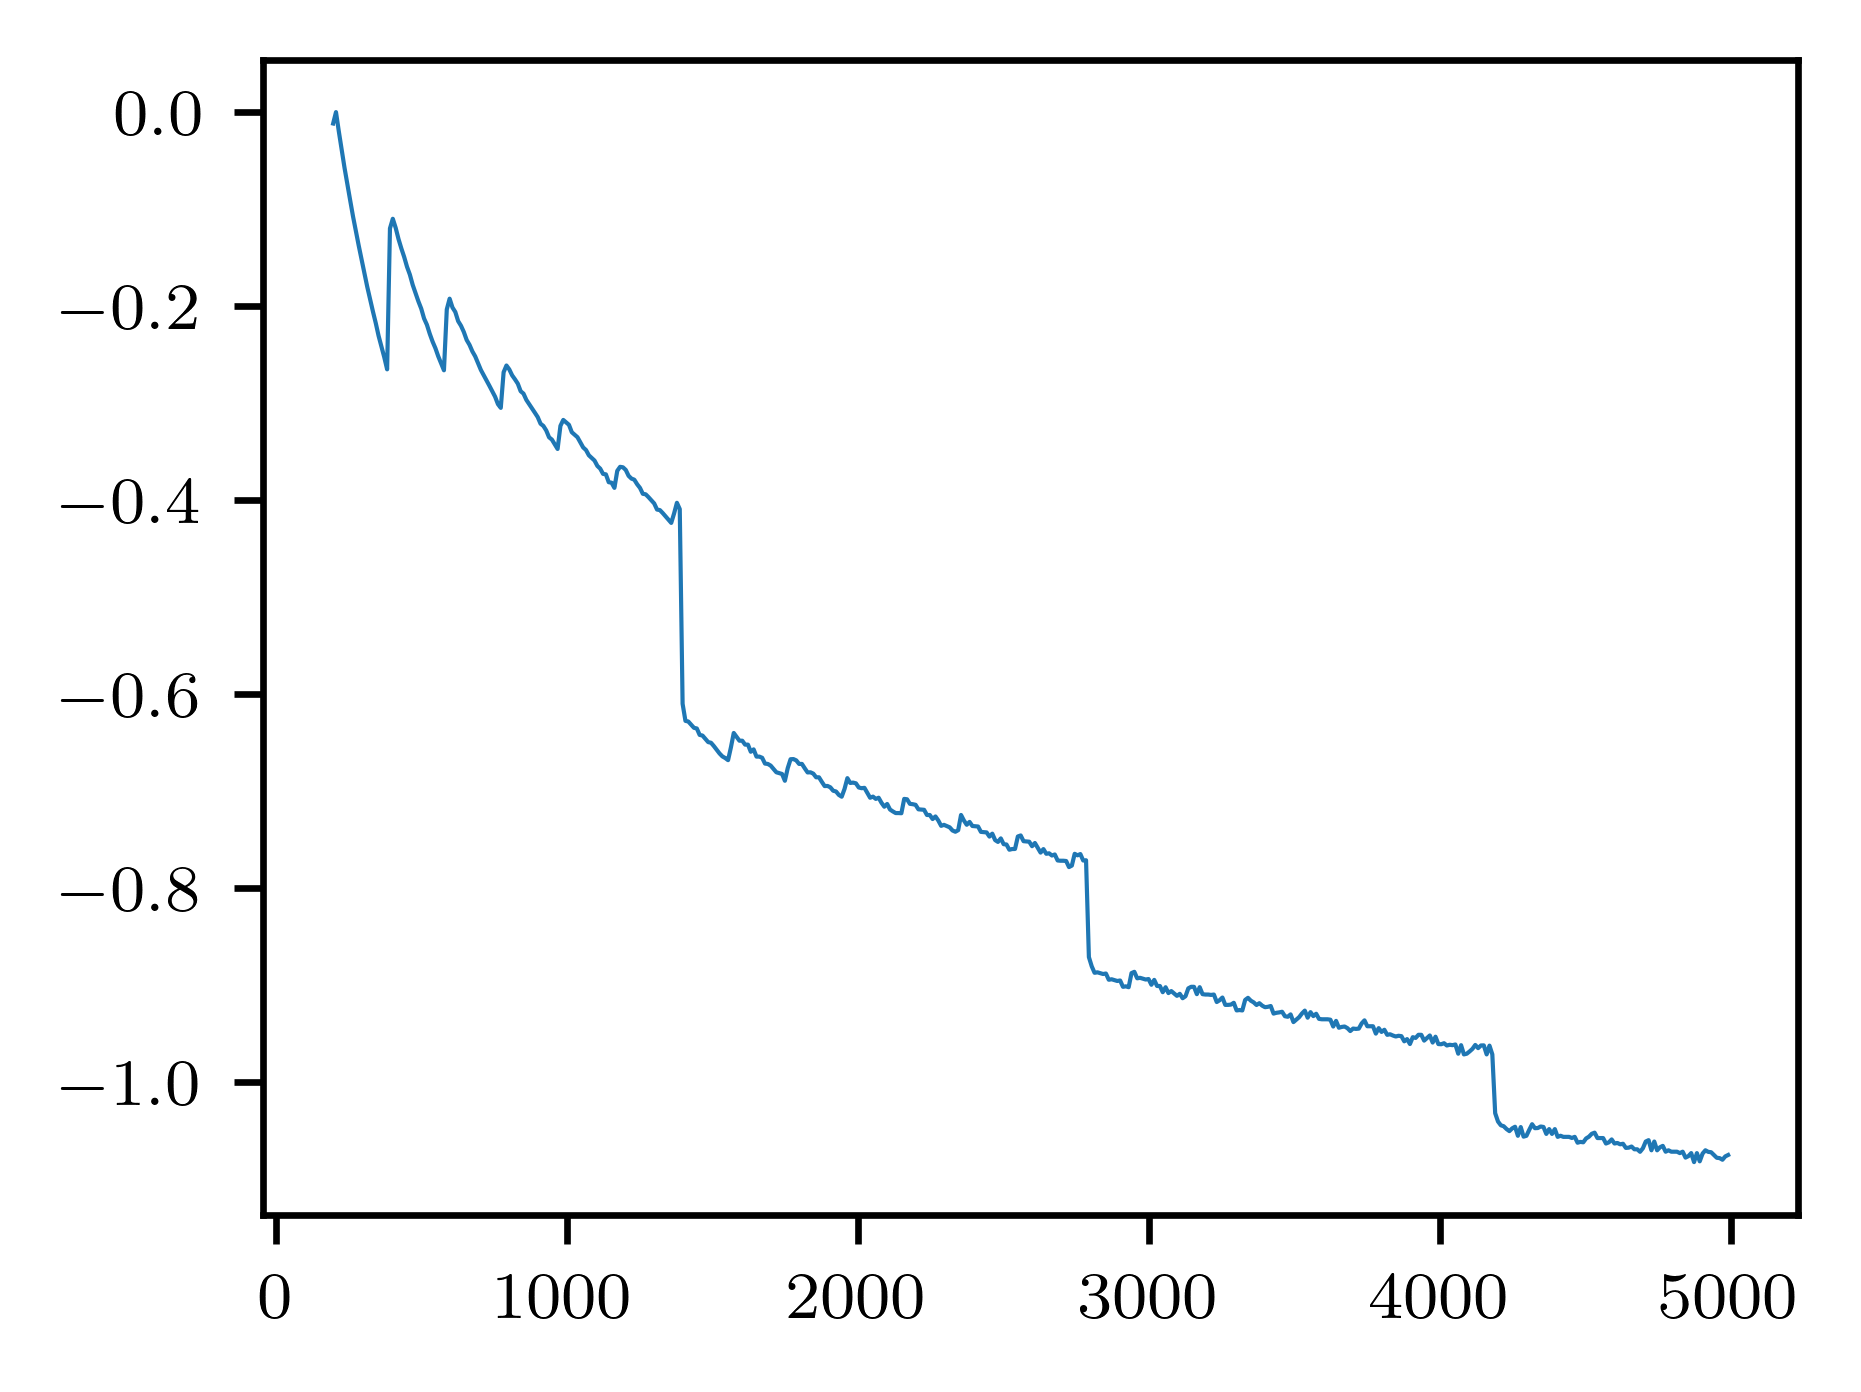

In [66]:
subdivision = 1024
notes = np.arange(-14*subdivision, 20*subdivision)
freqs = 440 * np.power(2, notes/(12*subdivision))
Ss = np.array([sawtooth(f0, n_fft, sr) for f0 in freqs])
Ss_mean = Ss.mean(axis=0)
Ss_mean /= Ss_mean.max()
plt.plot(np.linspace(0, sr//2, n_fft//2+1), np.log10(Ss_mean))
plt.show()